# Regressão III - Tarefa

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings;   warnings.filterwarnings("ignore")

from scipy.interpolate import interp1d

%matplotlib inline

In [7]:
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [8]:
df.isnull().sum()

,0
index,0
sexo,0
posse_de_veiculo,0
posse_de_imovel,0
qtd_filhos,0
tipo_renda,0
educacao,0
estado_civil,0
tipo_residencia,0
idade,0


In [9]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median())
df.isnull().sum()

,0
index,0
sexo,0
posse_de_veiculo,0
posse_de_imovel,0
qtd_filhos,0
tipo_renda,0
educacao,0
estado_civil,0
tipo_residencia,0
idade,0


### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [10]:
df.index = pd.to_datetime(df.index)

print(f'''Meses presentes na base:
{[mes for mes in df.index.unique().strftime('%b%y')]}

{[mes for mes in df[df.index > (df.index.unique().max() - pd.DateOffset(months=3))].index.unique().strftime('%b%y')]}
''')

Meses presentes na base:
['Jan15', 'Feb15', 'Mar15', 'Apr15', 'May15', 'Jun15', 'Jul15', 'Aug15', 'Sep15', 'Oct15', 'Nov15', 'Dec15', 'Jan16', 'Feb16', 'Mar16']

['Jan16', 'Feb16', 'Mar16']



In [11]:
df_holdout = df[df.index > (df.index.unique().max() - pd.DateOffset(months=3))].copy()
df_holdout

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2016-01-01,12946,F,N,S,0,Pensionista,Médio,Casado,Casa,61,6.046575,2.0,2137.61
2016-01-01,8872,F,N,S,2,Servidor público,Superior completo,Casado,Casa,27,9.301370,4.0,13884.35
2016-01-01,16279,F,S,S,3,Assalariado,Médio,Casado,Casa,38,10.967123,5.0,11042.47
2016-01-01,8158,M,S,S,3,Servidor público,Médio,Casado,Casa,35,5.553425,5.0,1333.82
2016-01-01,9356,F,S,N,0,Assalariado,Médio,Viúvo,Casa,63,9.265753,1.0,17633.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-01,11611,F,N,S,1,Assalariado,Superior completo,Casado,Casa,29,8.665753,3.0,2930.40
2016-03-01,9144,F,N,S,0,Pensionista,Superior completo,Casado,Casa,65,6.046575,2.0,4084.37
2016-03-01,16583,F,N,S,0,Assalariado,Superior completo,Casado,Casa,33,10.969863,2.0,4339.66


### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [13]:
df_train = df[:'2015-12-01']
df_test = df['2016-01-01':]

In [14]:
X1 = patsy.dmatrices('''np.log(renda) ~ C(sexo)
                    + C(posse_de_veiculo)
                    + C(posse_de_imovel)
                    + qtd_filhos
                    + C(tipo_renda)
                    + C(educacao, Treatment(2))
                    + C(estado_civil)
                    + C(tipo_residencia, Treatment(1))
                    + idade
                    + tempo_emprego
                    + qt_pessoas_residencia
                    + 1''', df_train)

In [15]:
res = smf.ols(X1, data=df_train).fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=0.05)

resumo = res.summary()
resumo.tables[0]

Dep. Variable:,np.log(renda),R-squared:,0.430
Model:,OLS,Adj. R-squared:,0.430
Method:,Least Squares,F-statistic:,9.052e+04
Date:,"Tue, 13 Aug 2024",Prob (F-statistic):,0.00
Time:,21:07:52,Log-Likelihood:,-8.0161e+05
No. Observations:,600000,AIC:,1.603e+06
Df Residuals:,599995,BIC:,1.603e+06
Df Model:,5,,
Covariance Type:,nonrobust,,


In [16]:
tabela = pd.read_html(resumo.tables[1].as_html(), header=0, index_col=0)[0]
tabela.style.format(decimal=',', precision=4)\
    .highlight_between(
        left=.05, axis=1, props='color:red', subset='P>|t|'
).set_properties(**{'background-color': '#ffffb3'}, subset=['[0.025', '0.975]'])

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,"8,2031","0,0070","1197,8390","0,0000","8,1900","8,2170"
C(sexo)[T.M],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(posse_de_veiculo)[T.S],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(posse_de_imovel)[T.S],"0,1809","0,0030","70,7870","0,0000","0,1760","0,1860"
C(tipo_renda)[T.Bolsista],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(tipo_renda)[T.Empresário],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(tipo_renda)[T.Pensionista],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(tipo_renda)[T.Servidor público],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
"C(educacao, Treatment(2))[T.Fundamental]","0,0000","0,0000",nan,nan,"0,0000","0,0000"
"C(educacao, Treatment(2))[T.Médio]","0,0000","0,0000",nan,nan,"0,0000","0,0000"


### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [17]:
df_train['tempo_emprego_cat'], quebras = pd.qcut(df_train.tempo_emprego, 20, duplicates='drop', retbins=True)

In [18]:
df_train.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat
data_ref,,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,"(15.214, 20.216]"
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,"(9.082, 10.436]"
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,"(8.107, 9.082]"
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,"(0.816, 1.458]"
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,"(0.816, 1.458]"


In [19]:
quebras

array([ 0.11780822,  0.81643836,  1.45753425,  2.09589041,  2.91232877,
        3.63561644,  4.29863014,  4.93424658,  5.75890411,  6.04657534,
        6.35890411,  7.12054795,  8.10684932,  9.08219178, 10.43561644,
       12.46575342, 15.21369863, 20.21643836, 42.90684932])

In [20]:
df_train['tempo_emprego_cat'] = pd.cut(df_train.tempo_emprego, bins=quebras, duplicates='drop')
df_train.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat
data_ref,,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,"(15.214, 20.216]"
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,"(9.082, 10.436]"
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,"(8.107, 9.082]"
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,"(0.816, 1.458]"
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,"(0.816, 1.458]"


In [21]:
tab_perfil = pd.DataFrame()

tab_perfil['qtd_obs'] = df_train['tempo_emprego_cat'].value_counts()

df_train['log_renda']=np.log(df_train['renda'])

tab_perfil['log_renda_med'] = df_train.groupby('tempo_emprego_cat')['log_renda'].mean()

tab_perfil['tempo_emprego_med'] = df_train.groupby('tempo_emprego_cat')['tempo_emprego'].mean()

tab_perfil.sort_index(axis = 0, inplace = True)

tab_perfil.reset_index(inplace=True)

tab_perfil.rename(columns={'index':'tempo_emprego_cat'}, inplace=True)

tab_perfil

,tempo_emprego_cat,qtd_obs,log_renda_med,tempo_emprego_med
0,"(0.118, 0.816]",30207,8.365576,0.515397
1,"(0.816, 1.458]",30031,8.454323,1.125014
2,"(1.458, 2.096]",29736,8.569544,1.781261
3,"(2.096, 2.912]",30013,8.624148,2.510920
4,"(2.912, 3.636]",30408,8.755365,3.301180
5,"(3.636, 4.299]",29625,8.855078,3.987156
6,"(4.299, 4.934]",30109,8.903273,4.610421
7,"(4.934, 5.759]",29991,9.049495,5.367829
8,"(5.759, 6.047]",110726,9.040393,6.034873
9,"(6.047, 6.359]",9178,9.102869,6.200063


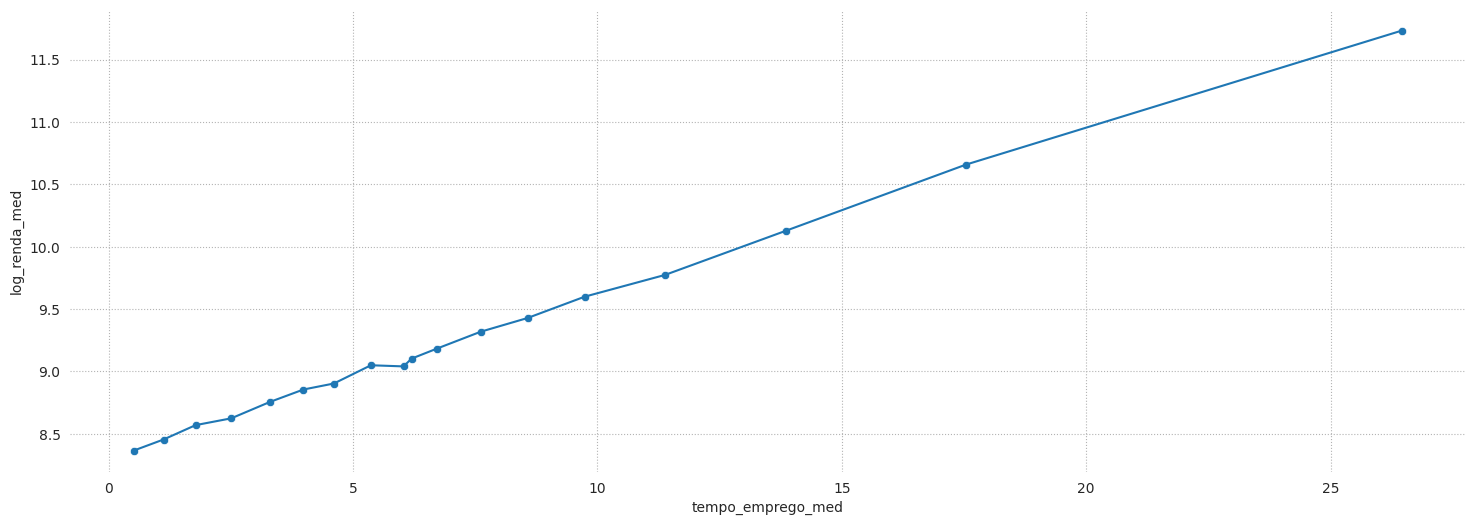

In [23]:
sns.set_style("whitegrid", {"grid.color": '.7', "grid.linestyle": ':'})

plt.figure(figsize=(18,6))

sns.scatterplot(x='tempo_emprego_med', y='log_renda_med', data=tab_perfil)

sns.lineplot(x='tempo_emprego_med', y='log_renda_med', data=tab_perfil)

sns.despine(left=True, bottom=True)

plt.show()

Ao analisar o gráfico, percebe-se rapidamente uma tendência linear constante, sugerindo inicialmente o uso de uma regressão linear simples. No entanto, é crucial lembrar da transformação logarítmica na variável dependente, que, se utilizada originalmente, evidenciaria o crescimento exponencial, como demonstrado pelo espaçamento crescente entre os valores à medida que aumentam. Assim, considera-se que tanto a categorização quanto a transformação logarítmica ou a regressão segmentada podem fornecer resultados satisfatórios. Contudo, o método Lowess pode ser a melhor escolha devido à sua capacidade de se ajustar ao formato exponencial, suavizando a curva de acordo com a necessidade.



### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


In [24]:
df_train_b = df_train.merge(tab_perfil, on='tempo_emprego_cat', how='left')
df_train_b.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat,log_renda,qtd_obs,log_renda_med,tempo_emprego_med
0,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,"(15.214, 20.216]",9.318131,29999.0,10.657687,17.538365
1,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,"(9.082, 10.436]",7.793508,30005.0,9.599298,9.741024
2,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,"(8.107, 9.082]",9.528769,29740.0,9.428302,8.572256
3,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,"(0.816, 1.458]",7.767196,30031.0,8.454323,1.125014
4,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,"(0.816, 1.458]",6.673020,30031.0,8.454323,1.125014


In [25]:
X2 = patsy.dmatrices('''log_renda ~
                    + C(posse_de_imovel)
                    + qtd_filhos
                    + idade
                    + tempo_emprego_cat
                    + 1''', df_train_b)

res_2 = smf.ols(X2, data=df_train_b).fit()
print(f'R-quadrado ajustado: {res_2.rsquared_adj:.2%}')

R-quadrado ajustado: 42.02%


In [26]:
%%time
lowess = sm.nonparametric.lowess(df_train_b.log_renda, df_train_b.tempo_emprego, frac=2/3)

CPU times: user 1min 29s, sys: 153 ms, total: 1min 29s
Wall time: 1min 33s


In [27]:
lowess_x = lowess[:, 0]
lowess_y = lowess[:, 1]

f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_train_b['tempo_emprego_lowess'] = f(df_train_b.tempo_emprego)
df_train_b.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat,log_renda,qtd_obs,log_renda_med,tempo_emprego_med,tempo_emprego_lowess
0,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,"(15.214, 20.216]",9.318131,29999.0,10.657687,17.538365,10.529949
1,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,"(9.082, 10.436]",7.793508,30005.0,9.599298,9.741024,9.568334
2,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,"(8.107, 9.082]",9.528769,29740.0,9.428302,8.572256,9.380380
3,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,"(0.816, 1.458]",7.767196,30031.0,8.454323,1.125014,8.487446
4,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,"(0.816, 1.458]",6.673020,30031.0,8.454323,1.125014,8.481435


In [28]:
X3 = patsy.dmatrices('''log_renda ~
                    + C(posse_de_imovel)
                    + qtd_filhos
                    + idade
                    + tempo_emprego_lowess
                    + 1''', df_train_b)

res_3 = smf.ols(X3, data=df_train_b).fit()
print(f'R-quadrado ajustado: {res_3.rsquared_adj:.2%}')

R-quadrado ajustado: 43.06%


### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

In [29]:
df_test['log_renda']=np.log(df_test['renda'])

df_test['pred_1'] = res.predict(df_test)

r = df_test[['pred_1', 'log_renda']].corr().iloc[0,1]
r**2

0.5376715049560687

In [30]:
df_test['tempo_emprego_cat'] = pd.cut(df_test.tempo_emprego, bins = quebras, duplicates='drop')

warnings.filterwarnings('ignore')
df_test['tempo_emprego_cat'].isna().value_counts()

,count
tempo_emprego_cat,
False,149991
True,9


In [31]:
df_test.dropna(inplace=True)
df_test['pred_2'] = res_2.predict(df_test)

r = df_test[['pred_2', 'log_renda']].corr().iloc[0,1]
r**2

0.5247549560888939

In [32]:
%%time
# Lowess
lowess = sm.nonparametric.lowess(df_test.log_renda, df_test.tempo_emprego, frac=2/3)

CPU times: user 20.5 s, sys: 41.6 ms, total: 20.5 s
Wall time: 23.7 s


In [33]:
lowess_x = lowess[:, 0]

lowess_y = lowess[:, 1]

# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_test['tempo_emprego_lowess'] = f(df_test.tempo_emprego)
df_test.head(2)

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,log_renda,pred_1,tempo_emprego_cat,pred_2,tempo_emprego_lowess
data_ref,,,,,,,,,,,,,,,,,,
2016-01-01,12946,F,N,S,0,Pensionista,Médio,Casado,Casa,61,6.046575,2.0,2137.61,7.667444,9.141801,"(5.759, 6.047]",9.091657,7.900725
2016-01-01,8872,F,N,S,2,Servidor público,Superior completo,Casado,Casa,27,9.301370,4.0,13884.35,9.538518,9.597904,"(9.082, 10.436]",9.618868,8.342858


In [34]:
df_test['pred_3'] = res_3.predict(df_test)
r = df_test[['pred_3', 'log_renda']].corr().iloc[0,1]
r**2

0.5384478691854501